In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras import backend
from keras_facenet import FaceNet

triplet_data_path="./Black/sub_max_hard_triplets.csv"
checkpoint_path="./Black/FACENET/"

2023-01-18 12:44:47.083946: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, (160, 160))
    image = tf.cast(image, tf.float32)
    image = (image - 127.5) / 127.5
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [3]:
# reading the CSV file
csvFile = pd.read_csv(triplet_data_path)

anchor_images   = csvFile.values[:,0].astype(str).tolist()
positive_images = csvFile.values[:,1].astype(str).tolist()
negative_images = csvFile.values[:,2].astype(str).tolist()
image_count = len(anchor_images)

anchor_dataset   = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

target_shape = (160, 160)
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))
 
batch_size = 100
fetch_size = 8

train_dataset = train_dataset.batch(batch_size, drop_remainder=False)
train_dataset = train_dataset.prefetch(fetch_size)

val_dataset = val_dataset.batch(batch_size, drop_remainder=False)
val_dataset = val_dataset.prefetch(fetch_size)

Metal device set to: AMD Radeon Pro 5500M


2023-01-18 12:44:51.660761: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 12:44:51.661793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-18 12:44:51.661861: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-18 12:44:51.662288: I tensorflow/core/common_runtime/pluggable_device/plug

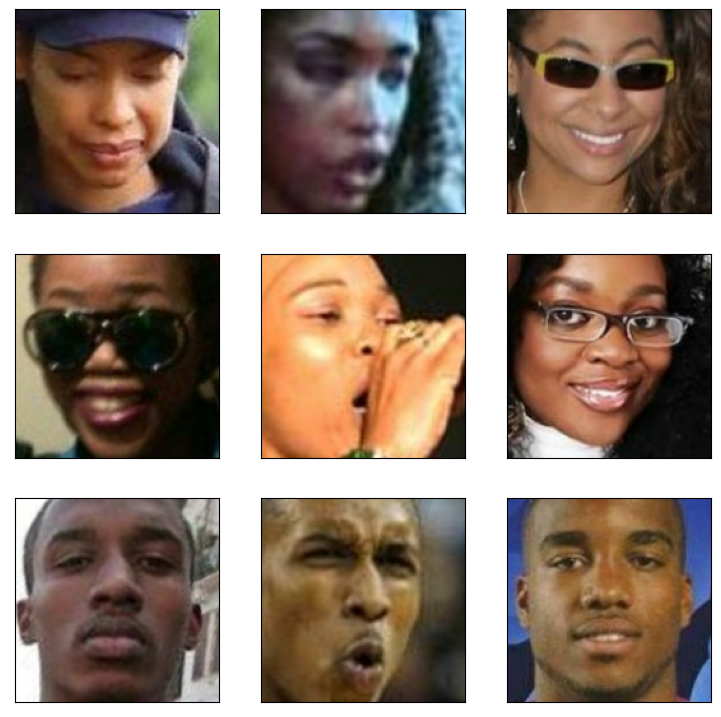

In [4]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        image = (image * 0.5) + 0.5
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [5]:
# create a facenet model
embedding = FaceNet(key = '20180402-114759',
        use_prebuilt=True,
        cache_folder='/Users/santhoshnarayanan/Documents/Turing/GPU/facenet_weights').model

# summarize input and output shape
print('Inputs: %s' % embedding.inputs)
print('Outputs: %s' % embedding.outputs)

Inputs: [<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_1')>]
Outputs: [<KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'normalize')>]


In [6]:
trainable = False
for layer in embedding.layers:
    if layer.name == "AvgPool":
        trainable = True
    layer.trainable = trainable
    
embedding.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)         (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (Batch  (None, None, None,   96         ['Conv2d_1a_3x3[0][0]']          
 Normalization)                 32)                                             

 Block35_1_Branch_2_Conv2d_0b_3  (None, None, None,   96         ['Block35_1_Branch_2_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_1_Branch_1_Conv2d_0a_1  (None, None, None,   0          ['Block35_1_Branch_1_Conv2d_0a_1x
 x1_Activation (Activation)     32)                              1_BatchNorm[0][0]']              
                                                                                                  
 Block35_1_Branch_2_Conv2d_0b_3  (None, None, None,   0          ['Block35_1_Branch_2_Conv2d_0b_3x
 x3_Activation (Activation)     32)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_1

 x1_Activation (Activation)     32)                              1_BatchNorm[0][0]']              
                                                                                                  
 Block35_2_Branch_2_Conv2d_0b_3  (None, None, None,   0          ['Block35_2_Branch_2_Conv2d_0b_3x
 x3_Activation (Activation)     32)                              3_BatchNorm[0][0]']              
                                                                                                  
 Block35_2_Branch_0_Conv2d_1x1   (None, None, None,   8192       ['Block35_1_Activation[0][0]']   
 (Conv2D)                       32)                                                               
                                                                                                  
 Block35_2_Branch_1_Conv2d_0b_3  (None, None, None,   9216       ['Block35_2_Branch_1_Conv2d_0a_1x
 x3 (Conv2D)                    32)                              1_Activation[0][0]']             
          

 Block35_3_Branch_0_Conv2d_1x1   (None, None, None,   8192       ['Block35_2_Activation[0][0]']   
 (Conv2D)                       32)                                                               
                                                                                                  
 Block35_3_Branch_1_Conv2d_0b_3  (None, None, None,   9216       ['Block35_3_Branch_1_Conv2d_0a_1x
 x3 (Conv2D)                    32)                              1_Activation[0][0]']             
                                                                                                  
 Block35_3_Branch_2_Conv2d_0c_3  (None, None, None,   9216       ['Block35_3_Branch_2_Conv2d_0b_3x
 x3 (Conv2D)                    32)                              3_Activation[0][0]']             
                                                                                                  
 Block35_3_Branch_0_Conv2d_1x1_  (None, None, None,   96         ['Block35_3_Branch_0_Conv2d_1x1[0
 BatchNorm

                                                                                                  
 Block35_4_Branch_2_Conv2d_0c_3  (None, None, None,   9216       ['Block35_4_Branch_2_Conv2d_0b_3x
 x3 (Conv2D)                    32)                              3_Activation[0][0]']             
                                                                                                  
 Block35_4_Branch_0_Conv2d_1x1_  (None, None, None,   96         ['Block35_4_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  32)                             ][0]']                           
                                                                                                  
 Block35_4_Branch_1_Conv2d_0b_3  (None, None, None,   96         ['Block35_4_Branch_1_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
          

 BatchNorm (BatchNormalization)  32)                             ][0]']                           
                                                                                                  
 Block35_5_Branch_1_Conv2d_0b_3  (None, None, None,   96         ['Block35_5_Branch_1_Conv2d_0b_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_5_Branch_2_Conv2d_0c_3  (None, None, None,   96         ['Block35_5_Branch_2_Conv2d_0c_3x
 x3_BatchNorm (BatchNormalizati  32)                             3[0][0]']                        
 on)                                                                                              
                                                                                                  
 Block35_5

                                                                  'Mixed_6a_Branch_1_Conv2d_1a_3x3
                                                                 _Activation[0][0]',              
                                                                  'Mixed_6a_Branch_2_MaxPool_1a_3x
                                                                 3[0][0]']                        
                                                                                                  
 Block17_1_Branch_1_Conv2d_0a_1  (None, None, None,   114688     ['Mixed_6a[0][0]']               
 x1 (Conv2D)                    128)                                                              
                                                                                                  
 Block17_1_Branch_1_Conv2d_0a_1  (None, None, None,   384        ['Block17_1_Branch_1_Conv2d_0a_1x
 x1_BatchNorm (BatchNormalizati  128)                            1[0][0]']                        
 on)      

                                                                                                  
 Block17_2_Branch_1_Conv2d_0c_7  (None, None, None,   114688     ['Block17_2_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    128)                             7_Activation[0][0]']             
                                                                                                  
 Block17_2_Branch_0_Conv2d_1x1_  (None, None, None,   384        ['Block17_2_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  128)                            ][0]']                           
                                                                                                  
 Block17_2_Branch_1_Conv2d_0c_7  (None, None, None,   384        ['Block17_2_Branch_1_Conv2d_0c_7x
 x1_BatchNorm (BatchNormalizati  128)                            1[0][0]']                        
 on)                                                                                              
          

                                                                                                  
 add_7 (Add)                    (None, None, None,   0           ['Block17_2_Activation[0][0]',   
                                896)                              'lambda_7[0][0]']               
                                                                                                  
 Block17_3_Activation (Activati  (None, None, None,   0          ['add_7[0][0]']                  
 on)                            896)                                                              
                                                                                                  
 Block17_4_Branch_1_Conv2d_0a_1  (None, None, None,   114688     ['Block17_3_Activation[0][0]']   
 x1 (Conv2D)                    128)                                                              
                                                                                                  
 Block17_4

 Block17_5_Branch_0_Conv2d_1x1   (None, None, None,   114688     ['Block17_4_Activation[0][0]']   
 (Conv2D)                       128)                                                              
                                                                                                  
 Block17_5_Branch_1_Conv2d_0c_7  (None, None, None,   114688     ['Block17_5_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    128)                             7_Activation[0][0]']             
                                                                                                  
 Block17_5_Branch_0_Conv2d_1x1_  (None, None, None,   384        ['Block17_5_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  128)                            ][0]']                           
                                                                                                  
 Block17_5_Branch_1_Conv2d_0c_7  (None, None, None,   384        ['Block17_5_Branch_1_Conv2d_0c_7x
 x1_BatchN

 lambda_10 (Lambda)             (None, None, None,   0           ['Block17_6_Conv2d_1x1[0][0]']   
                                896)                                                              
                                                                                                  
 add_10 (Add)                   (None, None, None,   0           ['Block17_5_Activation[0][0]',   
                                896)                              'lambda_10[0][0]']              
                                                                                                  
 Block17_6_Activation (Activati  (None, None, None,   0          ['add_10[0][0]']                 
 on)                            896)                                                              
                                                                                                  
 Block17_7_Branch_1_Conv2d_0a_1  (None, None, None,   114688     ['Block17_6_Activation[0][0]']   
 x1 (Conv2

 x7_Activation (Activation)     128)                             7_BatchNorm[0][0]']              
                                                                                                  
 Block17_8_Branch_0_Conv2d_1x1   (None, None, None,   114688     ['Block17_7_Activation[0][0]']   
 (Conv2D)                       128)                                                              
                                                                                                  
 Block17_8_Branch_1_Conv2d_0c_7  (None, None, None,   114688     ['Block17_8_Branch_1_Conv2d_0b_1x
 x1 (Conv2D)                    128)                             7_Activation[0][0]']             
                                                                                                  
 Block17_8_Branch_0_Conv2d_1x1_  (None, None, None,   384        ['Block17_8_Branch_0_Conv2d_1x1[0
 BatchNorm (BatchNormalization)  128)                            ][0]']                           
          

                                896)                                                              
                                                                                                  
 lambda_13 (Lambda)             (None, None, None,   0           ['Block17_9_Conv2d_1x1[0][0]']   
                                896)                                                              
                                                                                                  
 add_13 (Add)                   (None, None, None,   0           ['Block17_8_Activation[0][0]',   
                                896)                              'lambda_13[0][0]']              
                                                                                                  
 Block17_9_Activation (Activati  (None, None, None,   0          ['add_13[0][0]']                 
 on)                            896)                                                              
          

                                                                                                  
 Mixed_7a_Branch_2_Conv2d_0b_3x  (None, None, None,   589824     ['Mixed_7a_Branch_2_Conv2d_0a_1x1
 3 (Conv2D)                     256)                             _Activation[0][0]']              
                                                                                                  
 Mixed_7a_Branch_0_Conv2d_0a_1x  (None, None, None,   768        ['Mixed_7a_Branch_0_Conv2d_0a_1x1
 1_BatchNorm (BatchNormalizatio  256)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Mixed_7a_Branch_1_Conv2d_0a_1x  (None, None, None,   768        ['Mixed_7a_Branch_1_Conv2d_0a_1x1
 1_BatchNorm (BatchNormalizatio  256)                            [0][0]']                         
 n)       

                                                                                                  
 Block8_1_Branch_1_Conv2d_0b_1x  (None, None, None,   0          ['Block8_1_Branch_1_Conv2d_0b_1x3
 3_Activation (Activation)      192)                             _BatchNorm[0][0]']               
                                                                                                  
 Block8_1_Branch_0_Conv2d_1x1 (  (None, None, None,   344064     ['Mixed_7a[0][0]']               
 Conv2D)                        192)                                                              
                                                                                                  
 Block8_1_Branch_1_Conv2d_0c_3x  (None, None, None,   110592     ['Block8_1_Branch_1_Conv2d_0b_1x3
 1 (Conv2D)                     192)                             _Activation[0][0]']              
                                                                                                  
 Block8_1_

                                                                                                  
 Block8_2_Conv2d_1x1 (Conv2D)   (None, None, None,   689920      ['Block8_2_Concatenate[0][0]']   
                                1792)                                                             
                                                                                                  
 lambda_16 (Lambda)             (None, None, None,   0           ['Block8_2_Conv2d_1x1[0][0]']    
                                1792)                                                             
                                                                                                  
 add_16 (Add)                   (None, None, None,   0           ['Block8_1_Activation[0][0]',    
                                1792)                             'lambda_16[0][0]']              
                                                                                                  
 Block8_2_

 3_BatchNorm (BatchNormalizatio  192)                            [0][0]']                         
 n)                                                                                               
                                                                                                  
 Block8_4_Branch_1_Conv2d_0b_1x  (None, None, None,   0          ['Block8_4_Branch_1_Conv2d_0b_1x3
 3_Activation (Activation)      192)                             _BatchNorm[0][0]']               
                                                                                                  
 Block8_4_Branch_0_Conv2d_1x1 (  (None, None, None,   344064     ['Block8_3_Activation[0][0]']    
 Conv2D)                        192)                                                              
                                                                                                  
 Block8_4_Branch_1_Conv2d_0c_3x  (None, None, None,   110592     ['Block8_4_Branch_1_Conv2d_0b_1x3
 1 (Conv2D

                                                                  'Block8_5_Branch_1_Conv2d_0c_3x1
                                                                 _Activation[0][0]']              
                                                                                                  
 Block8_5_Conv2d_1x1 (Conv2D)   (None, None, None,   689920      ['Block8_5_Concatenate[0][0]']   
                                1792)                                                             
                                                                                                  
 lambda_19 (Lambda)             (None, None, None,   0           ['Block8_5_Conv2d_1x1[0][0]']    
                                1792)                                                             
                                                                                                  
 add_19 (Add)                   (None, None, None,   0           ['Block8_4_Activation[0][0]',    
          

In [7]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.norm(anchor - positive, ord='euclidean', axis= -1)
        an_distance = tf.norm(anchor - negative, ord='euclidean', axis= -1)
        return (ap_distance, an_distance)


anchor_input   = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [8]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.2):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [9]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path + "model.{epoch:02d}-{val_loss:.2f}.h5",
                                       monitor="val_loss",
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode="min",
                                       save_freq="epoch")]

siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), weighted_metrics=[])
siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=my_callbacks)

Epoch 1/20


2023-01-18 12:45:10.387840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - ETA: 0s - loss: 0.2780

2023-01-18 12:46:36.130020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


80/80 [==============================] - 123s 1s/step - loss: 0.2780 - val_loss: 0.2335
Epoch 2/20
80/80 [==============================] - 99s 1s/step - loss: 0.2043 - val_loss: 0.2084
Epoch 3/20
80/80 [==============================] - 119s 1s/step - loss: 0.1864 - val_loss: 0.1943
Epoch 4/20
80/80 [==============================] - 129s 2s/step - loss: 0.1748 - val_loss: 0.1836
Epoch 5/20
80/80 [==============================] - 157s 2s/step - loss: 0.1649 - val_loss: 0.1744
Epoch 6/20
80/80 [==============================] - 229s 3s/step - loss: 0.1562 - val_loss: 0.1631
Epoch 7/20
80/80 [==============================] - 204s 3s/step - loss: 0.1458 - val_loss: 0.1517
Epoch 8/20
 8/80 [==>...........................] - ETA: 2:11 - loss: 0.1178

KeyboardInterrupt: 

In [10]:
sample = next(iter(val_dataset))

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

In [11]:
distances = DistanceLayer()(
    anchor_embedding,
    positive_embedding,
    negative_embedding,
)
display(distances)

(<tf.Tensor: shape=(100,), dtype=float32, numpy=
 array([0.80745924, 0.7377142 , 0.55301386, 0.69007576, 0.9444775 ,
        0.8298003 , 0.50433254, 0.6798986 , 0.5549157 , 0.51207906,
        0.59131426, 0.5570884 , 0.9644809 , 0.6165205 , 0.5675472 ,
        1.0804933 , 0.5973815 , 0.7013974 , 0.6696865 , 1.0612366 ,
        0.5600793 , 0.9180042 , 0.67294455, 0.6260233 , 0.6775393 ,
        0.70948243, 0.5442841 , 0.9212267 , 0.7415982 , 0.68343073,
        0.7676652 , 0.59482324, 0.9757609 , 0.65222317, 0.81653196,
        0.6798992 , 0.73290354, 0.9595333 , 0.6355917 , 1.1753538 ,
        0.46497068, 0.88648295, 1.3339317 , 0.7767346 , 1.0672705 ,
        0.65746206, 1.1455454 , 0.86597127, 0.82891846, 0.84581196,
        0.8463363 , 0.7161455 , 0.9655712 , 0.82375324, 0.4729463 ,
        0.7315799 , 0.60862815, 0.73056006, 0.7600141 , 0.6782163 ,
        0.6792595 , 0.9018777 , 0.6729784 , 0.695803  , 0.79488504,
        0.79226255, 0.5553022 , 0.6605989 , 0.55960494, 0.87783295,

In [12]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive cosine similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative cosine similarity:", negative_similarity.numpy())

euclidean_similarity = metrics.RootMeanSquaredError()

positive_similarity = euclidean_similarity(anchor_embedding, positive_embedding)
print("Positive euclidean distance:", positive_similarity.numpy())

negative_similarity = euclidean_similarity(anchor_embedding, negative_embedding)
print("Negative euclidean distance:", negative_similarity.numpy())

Positive cosine similarity: 0.7014111
Negative cosine similarity: 0.6813148
Positive euclidean distance: 0.034152053
Negative euclidean distance: 0.035282627
